# Shear/Strain Parameterization

<div class="alert alert-info">

This section is available as jupyter notebook in the `docs/` directory or at https://github.com/modscripps/mixsea/tree/master/docs.

</div>

Import `mixsea` and a few other modules:

In [1]:
import mixsea as mx
import numpy as np
import matplotlib.pyplot as plt
import gsw

<div class="alert alert-info">

**Basic idea**
(Unfortunately shear-strain parameterizations for internal wave-driven mixing are not basic at all; this is as clear and concise a summary as possible.)

At the root of the shear-strain parameterization is the assumption of a scale separation between the production of turbulent kinetic energy $\mathcal{P}$ (extracted from a mean shear) at low wave numbers and its destruction by both viscous dissipation $\epsilon$ and vertical buoyancy flux $\overline{w'b'}$ at high wave numbers. In stationary turbulence, non-linear wave-wave interactions at some intermediate ("fine"-)scale $m_{c}$ must be responsible for this downscale energy flux, i.e.
\begin{equation}
-\mathcal{T}_{\text{IW}}(m_{c}) =  \mathcal{P} = - \epsilon + \overline{w'b'}
\end{equation}

Shear-strain parameterizations get their popular name based on the functional form $\mathcal{G}$ of the downscale transfer function that arises from either heuristic (<cite data-cite="Polzin2004">Polzin 2004</cite>) or ray-tracing (<cite data-cite="Henyey1986">Henyey et al. 1986</cite>) methods:
\begin{equation}
\mathcal{T}_{\text{IW}} = \mathcal{G}(E_{\text{KE}}, E_{\text{PE}}; \overline{N}, f),
\end{equation}
where:

- $E_{\text{KE}}$ is the *kinetic energy spectral density*, often expressed as the shear variance $\langle S^{2} \rangle = \int_{m_{\text{low}}}^{\min\{m_{\text{high}}, m_{c}\}} m^{2}E_{\text{KE}} \; \text{d} m$ integrated over a low wavenumber band [$m_{\text{low}}$, $m_{\text{high}}$], which is possibly cutoff early at $m_{c}$ as soon the cumulative shear variance increases above $1/6$ the amount required for wave breaking by shear instability $\big(\text{i.e. }R_{f} = \langle N^{2} \rangle / \langle S^{2} \rangle = 1/4 \big)$;
    
    
- $E_{\text{PE}}$ is the *potential energy spectral density*, often expressed in terms of a strain variance $\langle \xi_{z}^{2} \rangle$, where $xi$ is the displacement of a density surface, or in terms of the ratio  of shear to strain variance, $R_{\omega} = E_{\text{KE}}/E_{\text{PE}}$, which also doubles as a characteristic internal wave aspect ratio (strain variance also has a high cutoff wavenumber);
    
    
- $\overline{N}$ is the mean stratification; and 
    
    
- $f$ is the Coriolis frequency.
    
    
Strain-only parameterizations assume a characteristic constant shear to strain ratio and thus replace the shear variance with more readily available strain variance measurements, $\langle S^{2} \rangle \simeq \langle \xi_{z}^{2} \rangle R_{\omega}$.

In practice, such parameterizations are conventionally formulated as scalings of the <cite data-cite="Garrett1975">Garrett-Munk (1975)</cite> empirical internal wave energy spectrum. The exact forms of the parameterization used are described in the underlying functions' docstrings– see the Methods section of <cite data-cite="Gregg2003">Gregg (2003)</cite> for a concise example or <cite data-cite="Kunze2006">Kunze (2006)</cite> for a detailed exposition of the default method implemented in `mixsea`.
    
</div>

#### Read example data

In [2]:
ctd = mx.helpers.read_ctd_testfile()
ladcp = mx.helpers.read_ladcp_testfile()

Our example data contain some NaN values, as is common with observational datasets. Below we isolate the good data by removing NaNs. See the section [Missing Data](#Missing-Data) for using `nan_shearstrain` with input data that contains NaNs.

In [3]:
def nonan(data):
    notnan = [np.isfinite(v) for k, v in data.items()]
    notnan = np.vstack(notnan)
    notnan = np.all(notnan, axis=0)
    return notnan

notnan = nonan(ctd)
depth = ctd["depth"][notnan]
t = ctd["t"][notnan]
SP = ctd["SP"][notnan]
lon = ctd["lon"][0]
lat = ctd["lat"][0]

notnan = nonan(ladcp)
u = ladcp["u"][notnan]
v = ladcp["v"][notnan]
uz = ladcp["uz"][notnan]
vz = ladcp["vz"][notnan]
depth_sh = ladcp["depth"][notnan]

A quick overview plot of the data:

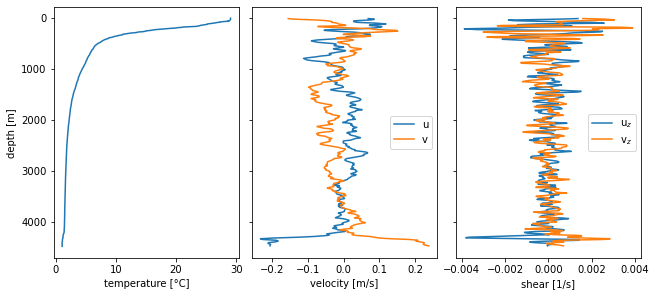

In [4]:
fig, ax = plt.subplots(
    nrows=1, ncols=3, figsize=(9, 4), constrained_layout=True, sharey=True
)
ax[0].plot(t, depth)
ax[0].set(ylabel="depth [m]", xlabel="temperature [°C]")
ax[1].plot(u, depth_sh, label="u")
ax[1].plot(v, depth_sh, label="v")
ax[1].set(xlabel="velocity [m/s]")
ax[1].legend()
ax[2].plot(uz, depth_sh, label=r"u$_{z}$")
ax[2].plot(vz, depth_sh, label=r"v$_{z}$")
ax[2].set(xlabel="shear [1/s]")
ax[2].legend()
ax[0].invert_yaxis()

## Example of the shear/strain internal wave parameterization

We begin by choosing our parameters. The key parameter choices are:

- `window_size`: the vertical extent of the spectral windows used to estimate shear/strain spectra;
- `min_size`: the shortest vertical wavelength resolved by the data (should be a factor of `window_size`); doesn't matter much in practice because we separately constrain the spectral windows with the two following parameters.
- `mi_sh`: index limits for integrating shear variance (excluding upper limit, following Python convention). Lower bound is generally just set to 0 so that the gravest mode included is the `window_size`; upper bound is generally set to 100-150 m.
- `mi_st`: index limits for integrating strain variance (excluding upper limit, following Python convention). Lower bound is generally set to 100-150 m and upper bound set to 10-20 m. In practice, the integration is often cut-off well before 10 m.

In [5]:
shst_params = dict()

# Center points of depth windows. Windows are half overlapping, i.e.
# their size (300m) is double the spacing here (150m).
window_size = 300.
min_size = 10.
dz = window_size / 2
shst_params["depth_bin"] = np.arange(dz, 10000., dz)
shst_params["window_size"] = window_size

# Set up wavenumber vector.
shst_params["m"] = np.arange(
    2 * np.pi / window_size, 2 * np.pi / min_size, 2 * np.pi / window_size
)

# Set up limits for shear and strain variance integrations
mi_sh = np.array([0, 3]); mii_sh = np.array(range(*mi_sh))
mi_st = np.array([2, 20]); mii_st = np.array(range(*mi_st))

shst_params["m_include_sh"] = mii_sh
shst_params["m_include_st"] = mii_st

# Convert indices to more intuitive length scales
m_sh = 2*np.pi/shst_params["m"][[mi_sh[0], mi_sh[1]-1]]
m_st = 2*np.pi/shst_params["m"][[mi_st[0], mi_st[1]-1]]
print(
    f"Wavenumber indices for integration:\n"
    f"- Shear is integrated from {round(m_sh[0])}m to {round(m_sh[1])}m scales.\n"
    f"- Strain is integrated from {round(m_st[0])}m to {round(m_st[1])}m."
)

shst_params["ladcp_is_shear"]=True
shst_params["return_diagnostics"]=True

Wavenumber indices for integration:
- Shear is integrated from 300m to 100m scales.
- Strain is integrated from 100m to 15m.


We now pass through our input data and paramter dictionary to the `shearstrain` function and retrieve the dissipation rate of turbulent kinetic energy $\epsilon$, the diapycnal diffusivity $\kappa_{\rho}$, and an optional dictionary of detailed diagnostics.

In [6]:
eps, krho, diag = mx.shearstrain.shearstrain(
    depth, t, SP, lon, lat, uz, vz, depth_sh, **shst_params
)

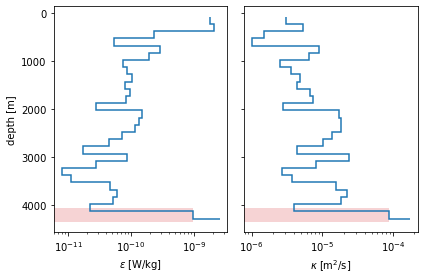

In [7]:
depth_bin = diag["depth_bin"]
depth_bin_edges = np.concatenate((
    [np.min(depth_bin)-dz/2],
    0.5*(depth_bin[1:]+depth_bin[:-1]),
    [np.max(depth_bin)-dz/2]
))
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 4), sharey=True
)
ax[0].stairs(eps, depth_bin_edges, orientation="horizontal", baseline=None, lw=1.5)
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]"
)
ax[0].invert_yaxis()

ax[1].stairs(krho, depth_bin_edges, orientation="horizontal", baseline=None, lw=1.5)
ax[1].set(
    xscale="log", xlabel=r"$\kappa$ [m$^{2}$/s]"
)

k = -2
ax[0].fill_betweenx(np.array([-dz, dz])+depth_bin[k], [0, 0], [eps[k], eps[k]], facecolor="C3", alpha=0.2)
ax[1].fill_betweenx(np.array([-dz, dz])+depth_bin[k], [0, 0], [krho[k], krho[k]], facecolor="C3", alpha=0.2)

plt.tight_layout()

Let's visualize the vertical profiles of the estimated mixing rates due to internal waves:

#### Deep dive for a single high-dissipation window near the bottom

Let's zoom in on the second to last window (shaded in red above), which exhibits abnormally strong shear variance and thus corresponds to a large dissipation rate, to get a better understanding of what the shear/strain variance and strain variance algorithms are doing.

Shear variance levels are 1.5 times higher than the GM spectrum over the low wavenumber band.


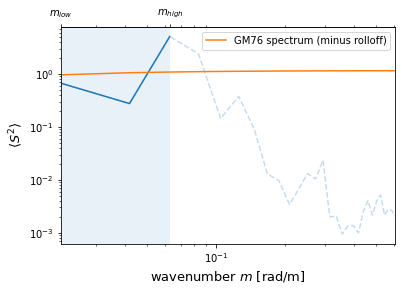

In [8]:
ax = plt.subplot()
plt.loglog(diag["m"][mii_sh], diag['P_shear'][k][mii_sh])
plt.loglog(diag["m"], diag['P_shear'][k], "C0--", alpha=0.25)
S_shear_gm, P_shear_gm = mx.shearstrain.gm_shear_variance(diag['m'], mii_sh, diag["Nmseg"][k])
plt.loglog(diag["m"], P_shear_gm, label="GM76 spectrum (minus rolloff)")
ylims = plt.gca().get_ylim()
plt.fill_between(diag['m'][[mi_sh[0], mi_sh[1]-1]], [ylims[0], ylims[0]], [ylims[1], ylims[1]], alpha=0.1)
plt.ylim(ylims)
plt.xlim(diag["m"][0], diag["m"][-1])
plt.ylabel(r"$\langle S^{2} \rangle$", fontsize=13)
plt.xlabel(r"wavenumber $m$ [rad/m]", fontsize=13)
plt.legend()

def same(x):
    return x

secax = ax.secondary_xaxis('top', functions=(same, same))
secax.set_xticks(
    [diag['m'][mii_sh[0]], diag['m'][mii_sh[-1]]], minor=False
)
secax.set_xticklabels([r"$m_{low}$", r"$m_{high}$"])

var_ratio = diag['Int_sh'][k]/diag["Int_sh_gm"][k]
print(f"Shear variance levels are {round(var_ratio,1)} times higher than the GM spectrum over the low wavenumber band.")

Strain variance levels are 22.8 times higher than the GM spectrum over the low wavenumber band.


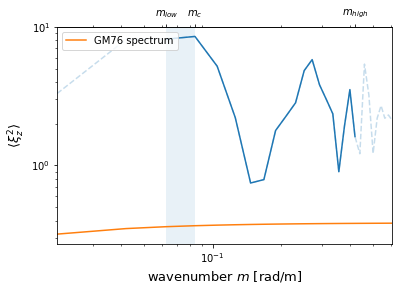

In [9]:
ax = plt.subplot()
plt.loglog(diag["m"][mii_st], diag['P_strain'][k][mii_st])
plt.loglog(diag["m"], diag['P_strain'][k], "C0--", alpha=0.25)
S_strain_gm, P_strain_gm = mx.shearstrain.gm_strain_variance(diag['m'], mii_st, diag["Nmseg"][k])
plt.loglog(diag["m"], P_strain_gm, label="GM76 spectrum")
mii_st_cutoff = mii_st[diag["m"][mii_st] <= diag["Mmax_st"][k]]
S_strain_gm, P_strain_gm = mx.shearstrain.gm_strain_variance(diag['m'], mii_st_cutoff, diag["Nmseg"][k])
ylims = plt.gca().get_ylim()
plt.fill_between([diag['m'][mii_st_cutoff[0]], diag['Mmax_st'][k]], [ylims[0], ylims[0]], [ylims[1], ylims[1]], alpha=0.1)
plt.ylim(ylims)
plt.xlim(diag['m'][0], diag['m'][-1])
plt.ylabel(r"$\langle \xi_{z}^{2} \rangle$", fontsize=13)
plt.xlabel(r"wavenumber $m$ [rad/m]", fontsize=13)
plt.legend(loc="upper left")

secax = ax.secondary_xaxis('top', functions=(same, same))
secax.set_xticks(
    [diag['m'][mii_st[0]], diag['m'][mii_st[-1]], diag["Mmax_st"][k]], minor=False
)
secax.set_xticklabels([r"$m_{low}$", r"$m_{high}$", r"$m_{c}$"])

print(rf"Strain variance levels are {round(diag['Int_st'][k]/S_strain_gm,1)} times higher than the GM spectrum over the low wavenumber band.")

In this example, since the strain variance is much larger than GM levels while the shear variance is only slightly large than GM levels, the shear/strain ratio drops well below the GM level of $R_{\omega}$=3. Since shear/strain ratios of less than $1$ are unphysical for internal waves (for example the aspect ratio correction terms contain a factor $\sqrt{R_{\omega} - 1}$), we assert set any $R_{\omega} \leq 1$ to $R_{\omega}=1.01$.

In [10]:
print(f"Raw shear/strain ratio: {round(diag['Rwtot'][k], 2)}, corrected ratio: {diag['Rwcor'][k]}")

Raw shear/strain ratio: 0.2, corrected ratio: 1.01


#### Decomposing the terms of the parameterization

The dissipation rate for the shear/strain parameterization is given as:
\begin{equation}
\epsilon_{\text{fine}} = \epsilon_{0} \; \frac{\overline{N}^{2}}{N_{0}^{2}} \; \frac{\langle S^{2} \rangle}{\langle S^{2}_{\text{GM}} \rangle} \; h_{1}(R_{\omega}) \; L(f, \overline{N})
\end{equation}

It is useful to plot their vertical profiles to get a sense of how their various dependencies combine to produce a typical dissipation rate profile, where the grey dashed lines denote the reference values for the GM spectrum.

Verification successful: True


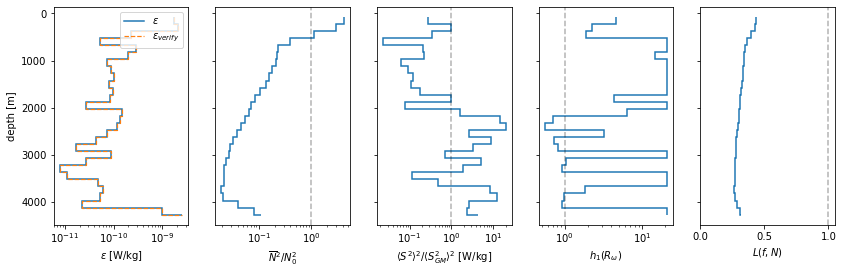

In [11]:
import gsw
N0 = 5.24e-3
f = np.absolute(gsw.f(ctd["lat"][0]))

fig, ax = plt.subplots(
    nrows=1, ncols=5, figsize=(14, 4), sharey=True
)
ax[0].stairs(
    eps, depth_bin_edges, label=r"$\epsilon$",
    orientation="horizontal", baseline=None, lw=1.5
)
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]"
)
ax[0].invert_yaxis()

ax[1].axvline(1., color="k", alpha=0.3, ls="--")
ax[1].stairs(
    diag["Nmseg"]**2 / N0**2, depth_bin_edges,
    orientation="horizontal", baseline=None, lw=1.5
)
ax[1].set(
    xscale="log", xlabel=r"$\overline{N}^{2}/N_{0}^{2}$"
)

ax[2].axvline(1., color="k", alpha=0.3, ls="--")
ax[2].stairs(
    diag["Int_sh"]**2 / diag["Int_sh_gm"]**2, depth_bin_edges,
    orientation="horizontal", baseline=None, lw=1.5
)
ax[2].set(
    xscale="log", xlabel=r"$\langle S^{2} \rangle^{2} / \langle S^{2}_{GM} \rangle^{2}$ [W/kg]"
)

ax[3].axvline(mx.shearstrain.aspect_ratio_correction_shst(3.), color="k", alpha=0.3, ls="--")
ax[3].stairs(
    mx.shearstrain.aspect_ratio_correction_shst(diag["Rwcor"]), depth_bin_edges,
    orientation="horizontal", baseline=None, lw=1.5
)
ax[3].set(
    xscale="log", xlabel=r"$h_{1}(R_{\omega})$"
)

ax[4].axvline(1., color="k", alpha=0.3, ls="--")
ax[4].stairs(
    mx.shearstrain.latitude_correction(f, diag["Nmseg"]), depth_bin_edges,
    orientation="horizontal", baseline=None, lw=1.5
)
ax[4].set(
    xlabel=r"$L(f, N)$"
)

eps0 = 7.8e-10
eps_verify = (
    eps0*
    diag["Nmseg"]**2 / N0**2 *
    diag["Int_sh"]**2 / diag["Int_sh_gm"]**2 *
    mx.shearstrain.aspect_ratio_correction_shst(diag["Rwcor"]) *
    mx.shearstrain.latitude_correction(f, diag["Nmseg"])
)
ax[0].stairs(
    eps_verify, depth_bin_edges, label=r"$\epsilon_{verify}$",
    orientation="horizontal", baseline=None,
    lw=1.2, ls="--", alpha=1.
)
ax[0].legend()

print(f"Verification successful: {np.isclose(eps_verify, eps).all()}")

## Stratification Smoothing Techniques

`shearstrain` allows to select between two different techniques for obtaining a smooth profile of $N^2$. Adiabatic leveling is the default (used in the example above).

**Adiabatic Leveling** finds locally stable density gradients to calculate a smooth $N^2$ profile following Bray & Fofonoff (1981), see e.g. Polzin et al. (2014), Waterman et al. (2013, 2014).

**Polynomial Fitting** applies a second order polynomial fit to $N^2$ for each segment to obtain a smooth profile, compare e.g. Kunze et al. (2006), Whalen et al. (2012, 2015).

Run the shear/strain parameterization for both the techniques:

In [12]:
eps_PF, krho_PF, diag_PF = mx.shearstrain.shearstrain(
    depth, t, SP, lon, lat, uz, vz, depth_sh, smooth="PF", **shst_params
)

Compare results from the two techniques:

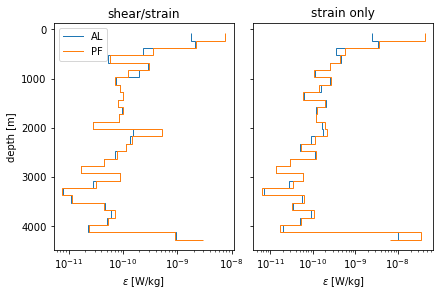

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 4), constrained_layout=True, sharey=True
)
opts = dict(orientation="horizontal", baseline=None)

# shear/strain
ax[0].stairs(eps, depth_bin_edges, label="AL", **opts)
ax[0].stairs(eps_PF, depth_bin_edges, label="PF", **opts)
ax[0].legend(loc="upper left")
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]", title="shear/strain"
)
ax[0].invert_yaxis()

# strain only
ax[1].stairs(diag["eps_st"], depth_bin_edges, label="AL", **opts)
ax[1].stairs(diag_PF["eps_st"], depth_bin_edges, label="PF", **opts)
ax[1].set(xscale="log", xlabel=r"$\epsilon$ [W/kg]", title="strain only");

Results differ mostly for the upper ocean and the bottom layer. Note that we do not filter out parts of the profile where the shear/strain parameterization may not apply as underlying assumptions are violated, i.e. near the surface mixed layer and in the lowly stratified layer of the abyssal flow through the Samoan Passage.

<a id='Missing-Data'></a>

## Missing Data

Here we pass the data as is, containing NaNs, to `nan_shearstrain`.

In [14]:
eps_nan, krho_nan, diag_nan = mx.shearstrain.nan_shearstrain(
    ctd["depth"],
    ctd["t"],
    ctd["SP"],
    ctd["lon"],
    ctd["lat"],
    ladcp["uz"],
    ladcp["vz"],
    ladcp["depth"],
    **shst_params
)

Compare with result of `shearstrain` from above - the results should be the same. Here we apply only the polynomial fit method for obtaining strain.

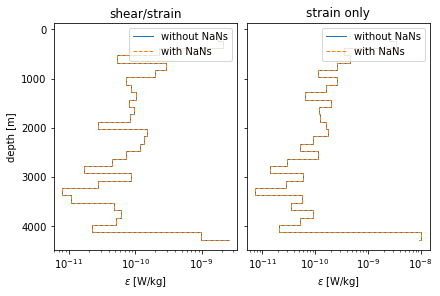

In [15]:
depth_bin_nan = diag_nan["depth_bin"]
depth_bin_nan_edges = np.concatenate((
    [np.min(depth_bin_nan)-dz/2],
    0.5*(depth_bin_nan[1:]+depth_bin_nan[:-1]),
    [np.max(depth_bin_nan)-dz/2]
))


fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 4), constrained_layout=True, sharey=True
)

# shear/strain
ax[0].stairs(eps, depth_bin_edges, label="without NaNs", **opts)
ax[0].stairs(eps_nan, depth_bin_nan_edges, label="with NaNs", linestyle="--", **opts)
ax[0].legend()
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]", title="shear/strain"
)
ax[0].invert_yaxis()

# strain only
ax[1].stairs(diag["eps_st"], depth_bin_edges, label="without NaNs", **opts)
ax[1].stairs(diag_nan["eps_st"], depth_bin_nan_edges, label="with NaNs", linestyle="--", **opts)
ax[1].legend()
ax[1].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", title="strain only",
);

Note that there may be cases where simply removing all missing data from the input, as is happening in `nan_shearstrain`, will lead to unphysical results! 